Final Grade: 50/50

In [ ]:
%%bash
pip install pyspark &> /dev/null
data_file=satisfaction.csv
echo ${data_file}

# If the data file does not exist in the colab environment
if [[ ! -f ./${data_file} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/weizk1998/airline/main/${data_file} &>/dev/null
fi

satisfaction.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml import feature, Pipeline, classification
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.sql.types import IntegerType
from pyspark.sql import SparkSession
import seaborn as sn

spark = SparkSession.builder.appName('spark-intro').getOrCreate()
sc = spark.sparkContext

In [ ]:
satisfaction = spark.read.csv('satisfaction.csv',inferSchema = True, header = True)

# **Data Collection/ Cleaning**

In [ ]:
# Because the raw data is large, we take a sample data to analyze.
satisfaction_new = satisfaction.sample(fraction=10000/satisfaction.count(),seed=100)  

In [ ]:
satisfaction_new.summary().show()

+-------+------------------+--------------------+------+-----------------+------------------+---------------+--------+------------------+------------------+---------------------------------+------------------+------------------+---------------------+----------------------+------------------+----------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------------+------------------------+
|summary|                id|     satisfaction_v2|Gender|    Customer Type|               Age| Type of Travel|   Class|   Flight Distance|      Seat comfort|Departure/Arrival time convenient|    Food and drink|     Gate location|Inflight wifi service|Inflight entertainment|    Online support|Ease of Online booking|  On-board service|  Leg room service|  Baggage handling|   Checkin service|       Cleanliness|   Online boarding|Departure Delay in Minutes|Arrival Delay in Minutes|
+-------+------------------+--------

In [ ]:
satisfaction_new = satisfaction_new.dropna()  # The column of "Arrival Delay in Minutes" has some null values, so we remove all rows that have na values.

In [ ]:
satisfaction_new.show(5)

+-----+---------------+------+--------------+---+---------------+--------+---------------+------------+---------------------------------+--------------+-------------+---------------------+----------------------+--------------+----------------------+----------------+----------------+----------------+---------------+-----------+---------------+--------------------------+------------------------+
|   id|satisfaction_v2|Gender| Customer Type|Age| Type of Travel|   Class|Flight Distance|Seat comfort|Departure/Arrival time convenient|Food and drink|Gate location|Inflight wifi service|Inflight entertainment|Online support|Ease of Online booking|On-board service|Leg room service|Baggage handling|Checkin service|Cleanliness|Online boarding|Departure Delay in Minutes|Arrival Delay in Minutes|
+-----+---------------+------+--------------+---+---------------+--------+---------------+------------+---------------------------------+--------------+-------------+---------------------+------------------

# **Data Explore**

## **Satisfaction from Different Classes**

In [ ]:
satisfaction_df_pd = satisfaction_new.toPandas()

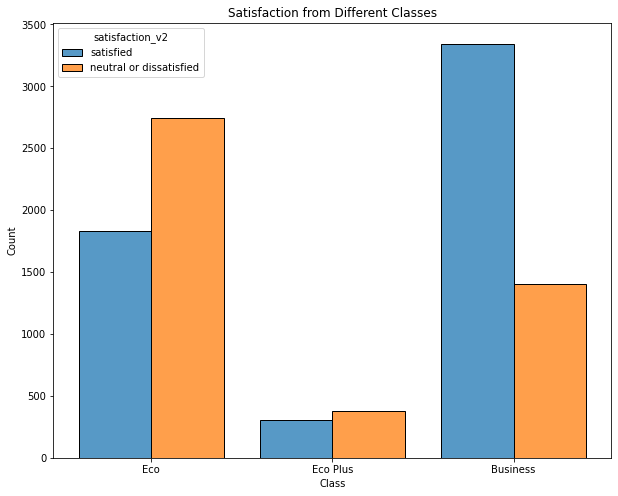

In [ ]:
plt.figure(figsize=(10,8))
ax = sn.histplot(data = satisfaction_df_pd, x = 'Class', 
                 hue = 'satisfaction_v2', multiple="dodge",
                 shrink=.8).set_title("Satisfaction from Different Classes")

## **Flight Distance of Different Customer Types**

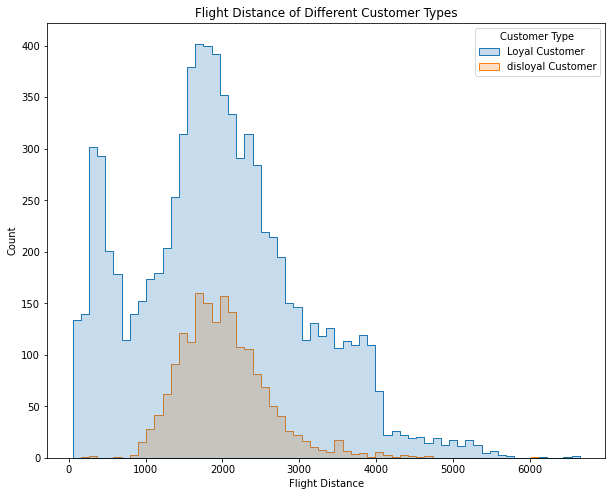

In [ ]:
plt.figure(figsize=(10,8))
ax = sn.histplot(data = satisfaction_df_pd, x = 'Flight Distance', 
                 hue = 'Customer Type', element="step").set_title("Flight Distance of Different Customer Types")

## **Percentage of Satisfaction for Delay of Departure & Arrival**

In [ ]:
def my_func(condition, start, end):
    return len(satisfaction_df_pd[(satisfaction_df_pd[condition].between(start,end)) & (satisfaction_df_pd['satisfaction_v2'] == 'satisfied')]) / len(satisfaction_df_pd[satisfaction_df_pd[condition].between(start,end)])

In [ ]:
depart30 = my_func('Departure Delay in Minutes', 0, 30)
depart60 = my_func('Departure Delay in Minutes', 31, 60)
depart90 = my_func('Departure Delay in Minutes', 61, 90)
depart1000 = my_func('Departure Delay in Minutes', 91, 2000)

In [ ]:
arrival30 = my_func('Arrival Delay in Minutes', 0, 30)
arrival60 = my_func('Arrival Delay in Minutes', 31, 60)
arrival90 = my_func('Arrival Delay in Minutes', 61, 90)
arrival1000 = my_func('Arrival Delay in Minutes', 91, 2000)

In [ ]:
data = {'Delay Period': ['<30', '30-60', '60-90', '>90'],
        'Departure Satisfaction': [depart30, depart60, depart90, depart1000],
        'Arrival Satisfaction': [arrival30,arrival60,arrival90,arrival1000]}
delaysatisfaction_df = pd.DataFrame(data)
delaysatisfaction_df

,Delay Period,Departure Satisfaction,Arrival Satisfaction
0,<30,0.564287,0.565846
1,30-60,0.469154,0.443228
2,60-90,0.473333,0.486486
3,>90,0.378973,0.389706


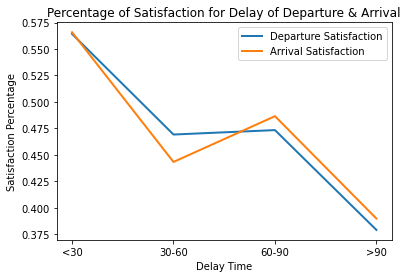

In [ ]:
x = delaysatisfaction_df['Delay Period']
y = delaysatisfaction_df['Departure Satisfaction']
y2 = delaysatisfaction_df['Arrival Satisfaction']

fig, ax = plt.subplots()
ax.plot(x,y,linewidth=2.0,label='Departure Satisfaction')
ax.plot(x,y2,linewidth=2.0,label='Arrival Satisfaction')

plt.title("Percentage of Satisfaction for Delay of Departure & Arrival")
plt.legend()
plt.xlabel('Delay Time')
plt.ylabel('Satisfaction Percentage')
plt.show()

# **Methodology (Feature Engine)**

In [ ]:
# Convert the column of satisfaction into 0 and 1.
def satis(satisfaction):
  if satisfaction == 'satisfied':
    return 1
  else:
    return 0

udf_satis = fn.udf(satis, IntegerType())
satisfaction_new = satisfaction_new.withColumn("satisfaction", udf_satis("satisfaction_v2"))

In [ ]:
# Encode all string variables.
si1 = feature.StringIndexer(inputCol='Gender', outputCol='encoded_Gender')
si2 = feature.StringIndexer(inputCol='Customer Type', outputCol='encoded_Customer_Type')
si3 = feature.StringIndexer(inputCol='Type of Travel', outputCol='encoded_Type_of_Travel')
si4 = feature.StringIndexer(inputCol='Class', outputCol='encoded_Class')

si_pipe = Pipeline(stages = [si1,si2,si3,si4]).fit(satisfaction_new)

satisfaction_new = si_pipe.transform(satisfaction_new)

training_df, validation_df, testing_df = satisfaction_new.randomSplit([0.6, 0.2, 0.2], seed=100) # Split data set into training, validation and testing data set.

# **Prediction**

In [ ]:
enable_grid_search = False

## **Predict overall satisfaction**

### Model 1: Logistic Regression

In [ ]:
# Using all variables to predict overall satisfaction. Using grid search and 3 times cross falidation.
if enable_grid_search:
  va = feature.VectorAssembler(inputCols=['Age','Flight Distance','Seat comfort',
                                        'Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding','Departure Delay in Minutes','Arrival Delay in Minutes',
                                        'encoded_Gender','encoded_Customer_Type','encoded_Type_of_Travel',
                                        'encoded_Class'],outputCol='features')

  lr = classification.LogisticRegression().\
    setLabelCol('satisfaction').\
    setFeaturesCol('features')

  paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .build()

  satisfaction_pipe = Pipeline(stages = [va,lr])

  evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())
  crossval = CrossValidator(estimator=satisfaction_pipe, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)

  final_model_fitted = crossval.fit(training_df)
  final_model_fitted.avgMetrics

  best_model_index = np.argmax(final_model_fitted.avgMetrics)
  print(paramGrid[best_model_index])

In [ ]:
# Using best model to predict.
va = feature.VectorAssembler(inputCols=['Age','Flight Distance','Seat comfort',
                                        'Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding','Departure Delay in Minutes','Arrival Delay in Minutes',
                                        'encoded_Gender','encoded_Customer_Type','encoded_Type_of_Travel',
                                        'encoded_Class'],outputCol='features')

lr = classification.LogisticRegression().\
    setLabelCol('satisfaction').\
    setFeaturesCol('features').\
    setElasticNetParam(0.).\
    setRegParam(0.01)

satisfaction_pipe = Pipeline(stages = [va,lr])
final_model_fitted = satisfaction_pipe.fit(training_df)
evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), rawPredictionCol=lr.getRawPredictionCol())

In [ ]:
# Get AUC score.
evaluator.evaluate(final_model_fitted.transform(validation_df))

0.9130275194819851

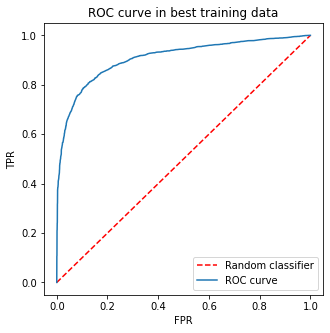

In [ ]:
# Get ROC curve.
tpr1 = final_model_fitted.stages[-1].summary.roc.select('TPR').toPandas()
fpr1 = final_model_fitted.stages[-1].summary.roc.select('FPR').toPandas()

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--',label = 'Random classifier')
plt.plot(fpr1,tpr1,label = 'ROC curve')
plt.title('ROC curve in best training data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

### Model 2: Random Forest

In [ ]:
# Using all variables to predict overall satisfaction. Using grid search.
if enable_grid_search:
    va = feature.VectorAssembler(inputCols=['Age','Flight Distance','Seat comfort',
                                        'Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding','Departure Delay in Minutes','Arrival Delay in Minutes',
                                        'encoded_Gender','encoded_Customer_Type','encoded_Type_of_Travel',
                                        'encoded_Class'],
                                 outputCol='features')
    rf = classification.RandomForestClassifier(featuresCol='features', labelCol='satisfaction')
    rf_pipeline = Pipeline(stages=[va,rf])

    grid = ParamGridBuilder().\
        addGrid(rf.numTrees, [20,30,40]).\
        addGrid(rf.maxDepth, [10,20,30]).\
        build()

    all_models = []
    for j in range(len(grid)):
      model = rf_pipeline.fit(training_df, grid[j])
      all_models.append(model)

    evaluator = BinaryClassificationEvaluator(labelCol=rf.getLabelCol(), rawPredictionCol=rf.getRawPredictionCol())
    aucs = [evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    print(aucs)

    best_model_idx = np.argmax(aucs)
    best_model = all_models[best_model_idx]

    print(grid[best_model_idx])
    pass

In [ ]:
# Using best model to predict.
va = feature.VectorAssembler(inputCols=['Age','Flight Distance','Seat comfort',
                                        'Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding','Departure Delay in Minutes','Arrival Delay in Minutes',
                                        'encoded_Gender','encoded_Customer_Type','encoded_Type_of_Travel',
                                        'encoded_Class'],
                             outputCol='features')
best_rf = classification.RandomForestClassifier(featuresCol='features', labelCol='satisfaction', numTrees=30, maxDepth=20)
best_rf_pipe = Pipeline(stages=[va,best_rf])

evaluator = BinaryClassificationEvaluator(labelCol=best_rf.getLabelCol(), rawPredictionCol=best_rf.getRawPredictionCol())
rf_train_auc = evaluator.evaluate(best_rf_pipe.fit(training_df).transform(training_df))
rf_validation_auc = evaluator.evaluate(best_rf_pipe.fit(training_df).transform(validation_df))
rf_test_auc = evaluator.evaluate(best_rf_pipe.fit(training_df).transform(testing_df))

print("rf_train_auc =", rf_train_auc)
print("rf_validation_auc =", rf_validation_auc)
print("rf_test_auc =", rf_test_auc)

rf_train_auc = 1.0
rf_validation_auc = 0.9814387807602035
rf_test_auc = 0.980286288548458


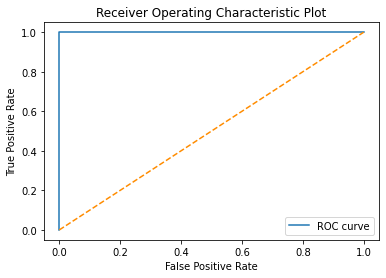

In [ ]:
# Get ROC curve.
best_rf_model = best_rf_pipe.fit(training_df).stages[-1]
fpr = best_rf_model.summary.roc.select('FPR').toPandas()
tpr = best_rf_model.summary.roc.select('TPR').toPandas()
plt.plot(fpr,tpr,label='ROC curve')
plt.plot([0,1], [0,1], color='darkorange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
plt.legend(loc='lower right')

### Model 3: GBT

In [ ]:
# Using all variables to predict overall satisfaction. Using grid search.
if enable_grid_search:
    va = feature.VectorAssembler(inputCols=['Age','Flight Distance','Seat comfort',
                                        'Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding','Departure Delay in Minutes','Arrival Delay in Minutes',
                                        'encoded_Gender','encoded_Customer_Type','encoded_Type_of_Travel',
                                        'encoded_Class'],
                                 outputCol='features')
    gbt = classification.GBTClassifier(featuresCol='features', labelCol='satisfaction')
    gbt_pipeline = Pipeline(stages=[va, gbt])

    grid = ParamGridBuilder().\
        addGrid(gbt.maxIter, [30,40,50]).\
        addGrid(gbt.maxDepth, [5,10,15]).\
        build()

    all_models = []
    for j in range(len(grid)):
      model = gbt_pipeline.fit(training_df, grid[j])
      all_models.append(model)
    
    evaluator = BinaryClassificationEvaluator(labelCol=gbt.getLabelCol(), rawPredictionCol=gbt.getPredictionCol())
    aucs = [evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    print(aucs)

    best_model_idx = np.argmax(aucs)
    best_model = all_models[best_model_idx]

    print(grid[best_model_idx])
    pass

In [ ]:
# Using best model to predict and get AUC scores.
va = feature.VectorAssembler(inputCols=['Age','Flight Distance','Seat comfort',
                                        'Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding','Departure Delay in Minutes','Arrival Delay in Minutes',
                                        'encoded_Gender','encoded_Customer_Type','encoded_Type_of_Travel',
                                        'encoded_Class'],
                             outputCol='features')

best_gbt = classification.GBTClassifier(featuresCol='features', labelCol='satisfaction', maxIter=50, maxDepth=5)
best_gbt_pipe = Pipeline(stages=[va,best_gbt])

evaluator = BinaryClassificationEvaluator(labelCol=best_gbt.getLabelCol(), rawPredictionCol=best_gbt.getPredictionCol())
best_gbt_pipe_fitted = best_gbt_pipe.fit(training_df)
gbt_train_auc = evaluator.evaluate(best_gbt_pipe_fitted.transform(training_df))
gbt_validation_auc = evaluator.evaluate(best_gbt_pipe_fitted.transform(validation_df))

print("gbt_train_auc =", gbt_train_auc)
print("gbt_validation_auc =", gbt_validation_auc)

gbt_train_auc = 0.9519236771756803
gbt_validation_auc = 0.9314250816716653


### Model 4: Deep Learning

In [ ]:
# Using all variables to predict overall satisfaction. Using grid search and 3 times cross validation.
if enable_grid_search:
  mlp = classification.MultilayerPerceptronClassifier(seed=0).\
    setFeaturesCol('features').\
    setLabelCol('satisfaction').\
    setLayers([22*1,2])

  paramGrid = ParamGridBuilder() \
    .addGrid(mlp.stepSize, [0.1,0.2]) \
    .addGrid(mlp.maxIter, [100,200]) \
    .build()

  satisfaction_pipe3 = Pipeline(stages = [va,mlp])

  evaluator = BinaryClassificationEvaluator(labelCol=mlp.getLabelCol(), rawPredictionCol=mlp.getRawPredictionCol())
  crossval_1 = CrossValidator(estimator=satisfaction_pipe3, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=2)

  final_model_fitted3 = crossval_1.fit(training_df)

  best_model_index3 = np.argmax(final_model_fitted3.avgMetrics)
  print(paramGrid[best_model_index3])

In [ ]:
# Using best model to predict.
mlp = classification.MultilayerPerceptronClassifier(seed=0).\
    setFeaturesCol('features').\
    setLabelCol('satisfaction').\
    setStepSize(0.1).\
    setMaxIter(200).\
    setLayers([22*1,2])

satisfaction_pipe3 = Pipeline(stages = [va,mlp])
final_model_fitted3 = satisfaction_pipe3.fit(training_df)
evaluator = BinaryClassificationEvaluator(labelCol=mlp.getLabelCol(), rawPredictionCol=mlp.getRawPredictionCol())

In [ ]:
# Get AUC score.
evaluator.evaluate(final_model_fitted3.transform(validation_df))

0.5229109412842423

## **Get the Importance of each Sub-Satisfaction**

### Model 1: Logic Regression

In [ ]:
# Using sub-satisfaction to predict overall satisfaction. Using grid search and 3 times cross validation.
if enable_grid_search:
  va2 = feature.VectorAssembler(inputCols=['Seat comfort','Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding'],outputCol='features')

  lr2 = classification.LogisticRegression().\
        setLabelCol('satisfaction').\
        setFeaturesCol('features')

  paramGrid = ParamGridBuilder() \
    .addGrid(lr2.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(lr2.regParam, [0.1, 0.01, 0.001]) \
    .build()

  satisfaction_pipe2 = Pipeline(stages = [va2,lr2])

  evaluator = BinaryClassificationEvaluator(labelCol=lr2.getLabelCol(), rawPredictionCol=lr2.getRawPredictionCol())
  crossval = CrossValidator(estimator=satisfaction_pipe2, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)

  final_model_fitted2 = crossval.fit(training_df)
  final_model_fitted2.avgMetrics

  best_model_index2 = np.argmax(final_model_fitted2.avgMetrics)
  print(paramGrid[best_model_index2])

In [ ]:
# Using best model to predict.
va2 = feature.VectorAssembler(inputCols=['Seat comfort','Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding'],outputCol='features')

lr2 = classification.LogisticRegression().\
    setLabelCol('satisfaction').\
    setFeaturesCol('features').\
    setElasticNetParam(0.01).\
    setRegParam(0.001)

satisfaction_pipe2 = Pipeline(stages = [va2,lr2])
final_model_fitted2 = satisfaction_pipe2.fit(training_df)
evaluator = BinaryClassificationEvaluator(labelCol=lr2.getLabelCol(), rawPredictionCol=lr2.getRawPredictionCol())

In [ ]:
# Get AUC score.
evaluator.evaluate(final_model_fitted2.transform(validation_df))

0.8902452032275456

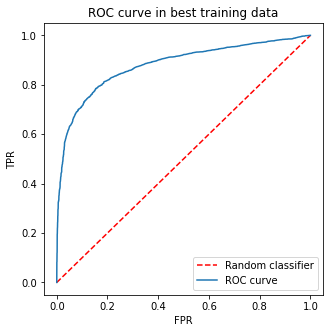

In [ ]:
# Get ROC curve.
tpr2 = final_model_fitted2.stages[-1].summary.roc.select('TPR').toPandas()
fpr2 = final_model_fitted2.stages[-1].summary.roc.select('FPR').toPandas()

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--',label = 'Random classifier')
plt.plot(fpr2,tpr2,label = 'ROC curve')
plt.title('ROC curve in best training data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [ ]:
# Get top 5 most important 
predictor = ['Seat comfort','Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding']
value = final_model_fitted2.stages[-1].coefficients.tolist()
predictor_list = pd.DataFrame({'predictor':predictor,'value':value}).sort_values(by='value',ascending=False).reset_index(drop=True)
predictor_list.head()

,predictor,value
0,Inflight entertainment,0.876890
1,Ease of Online booking,0.385357
2,On-board service,0.278976
3,Leg room service,0.274608
4,Checkin service,0.221677


### Model 2: Random Forest

In [ ]:
# Using sub-satisfaction to predict overall satisfaction. Using grid search.
if enable_grid_search:  
    va = feature.VectorAssembler(inputCols=['Seat comfort','Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding'],
                                 outputCol='features')
    rf = classification.RandomForestClassifier(featuresCol='features', labelCol='satisfaction')
    rf_pipeline = Pipeline(stages=[va,rf])

    grid = ParamGridBuilder().\
        addGrid(rf.numTrees, [20,30,40]).\
        addGrid(rf.maxDepth, [10,20,30]).\
        build()

    all_models = []
    for j in range(len(grid)):
      model = rf_pipeline.fit(training_df, grid[j])
      all_models.append(model)

    evaluator = BinaryClassificationEvaluator(labelCol=rf.getLabelCol(), rawPredictionCol=rf.getRawPredictionCol())
    aucs = [evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    print(aucs)

    best_model_idx = np.argmax(aucs)
    best_model = all_models[best_model_idx]

    print(grid[best_model_idx])
    pass

In [ ]:
# Using best model to predict and get AUC score.
va = feature.VectorAssembler(inputCols=['Seat comfort','Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding'],
                             outputCol='features')
best_rf = classification.RandomForestClassifier(featuresCol='features', labelCol='satisfaction', numTrees=30, maxDepth=20)
best_rf_pipe = Pipeline(stages=[va,best_rf])

evaluator = BinaryClassificationEvaluator(labelCol=best_rf.getLabelCol(), rawPredictionCol=best_rf.getRawPredictionCol())
model_fitted_6 = best_rf_pipe.fit(training_df)
rf_train_auc = evaluator.evaluate(model_fitted_6.transform(training_df))
rf_validation_auc = evaluator.evaluate(model_fitted_6.transform(validation_df))

print("rf_train_auc =", rf_train_auc)
print("rf_validation_auc =", rf_validation_auc)

rf_train_auc = 0.9998765334769467
rf_validation_auc = 0.9772286639310329


In [ ]:
# Get the top 5 most important features.
best_rf_model = model_fitted_6.stages[-1]
features = pd.Series(['Seat comfort','Departure/Arrival time convenient','Food and drink',
                      'Gate location','Inflight wifi service','Inflight entertainment',
                      'Online support','Ease of Online booking','On-board service',
                      'Leg room service','Baggage handling','Checkin service','Cleanliness',
                      'Online boarding'])
importance = best_rf_model.featureImportances.toArray()
rf_feature_importance = pd.DataFrame({'feature': features, 'importance': importance}).sort_values('importance', ascending=False)

rf_feature_importance.head()

,feature,importance
5,Inflight entertainment,0.251763
0,Seat comfort,0.138475
7,Ease of Online booking,0.103454
6,Online support,0.076307
9,Leg room service,0.060950


### Model 3: GBT

In [ ]:
# Using sub-satisfaction to predict overall satisfaction. Using grid search.
if enable_grid_search:
    va = feature.VectorAssembler(inputCols=['Seat comfort','Departure/Arrival time convenient','Food and drink',
                                            'Gate location','Inflight wifi service','Inflight entertainment',
                                            'Online support','Ease of Online booking','On-board service',
                                            'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                            'Online boarding'],
                                 outputCol='features')
    gbt = classification.GBTClassifier(featuresCol='features', labelCol='satisfaction')
    gbt_pipeline = Pipeline(stages=[va, gbt])

    grid = ParamGridBuilder().\
        addGrid(gbt.maxIter, [30,40,50]).\
        addGrid(gbt.maxDepth, [3,5,8]).\
        build()

    all_models = []
    for j in range(len(grid)):
      model = gbt_pipeline.fit(training_df, grid[j])
      all_models.append(model)
    
    evaluator = BinaryClassificationEvaluator(labelCol=gbt.getLabelCol(), rawPredictionCol=gbt.getPredictionCol())
    aucs = [evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    print(aucs)

    best_model_idx = np.argmax(aucs)
    best_model = all_models[best_model_idx]

    print(grid[best_model_idx])
    pass

In [ ]:
# Using best model to predict and get AUC score.
va = feature.VectorAssembler(inputCols=['Seat comfort','Departure/Arrival time convenient','Food and drink',
                                        'Gate location','Inflight wifi service','Inflight entertainment',
                                        'Online support','Ease of Online booking','On-board service',
                                        'Leg room service','Baggage handling','Checkin service','Cleanliness',
                                        'Online boarding'],
                             outputCol='features')

best_gbt = classification.GBTClassifier(featuresCol='features', labelCol='satisfaction', maxIter=50, maxDepth=8)
best_gbt_pipe = Pipeline(stages=[va,best_gbt])

evaluator = BinaryClassificationEvaluator(labelCol=best_gbt.getLabelCol(), rawPredictionCol=best_gbt.getPredictionCol())
best_gbt_pipe_fitted1 = best_gbt_pipe.fit(training_df)
gbt_train_auc = evaluator.evaluate(best_gbt_pipe_fitted1.transform(training_df))
gbt_validation_auc = evaluator.evaluate(best_gbt_pipe_fitted1.transform(validation_df))

print("gbt_train_auc =", gbt_train_auc)
print("gbt_validation_auc =", gbt_validation_auc)

gbt_train_auc = 0.9819115168042539
gbt_validation_auc = 0.9164935980290044


## **Predict Customer Type**

### Model 1: Logic Regression

In [ ]:
# Using related variables to predict customer type. Using grid search and 3 times cross validation.
if enable_grid_search:
  va3 = feature.VectorAssembler(inputCols=['Age','satisfaction','encoded_Gender','encoded_Type_of_Travel','Flight Distance',
                                          'encoded_Class'],outputCol='features')
  sc = feature.StandardScaler(withMean=True, inputCol='features')
  lr3 = classification.LogisticRegression().\
    setLabelCol('encoded_Customer_Type').\
    setFeaturesCol('features')

  paramGrid = ParamGridBuilder() \
    .addGrid(lr3.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(lr3.regParam, [0.1, 0.01, 0.001]) \
    .build()

  satisfaction_pipe3 = Pipeline(stages = [va3,sc,lr3])

  evaluator = BinaryClassificationEvaluator(labelCol=lr3.getLabelCol(), rawPredictionCol=lr3.getRawPredictionCol())
  crossval = CrossValidator(estimator=satisfaction_pipe3, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)

  final_model_fitted4 = crossval.fit(training_df)
  final_model_fitted4.avgMetrics

  best_model_index = np.argmax(final_model_fitted4.avgMetrics)
  print(paramGrid[best_model_index])

In [ ]:
# Using best model to predict.
va3 = feature.VectorAssembler(inputCols=['Age','satisfaction','encoded_Gender','encoded_Type_of_Travel','Flight Distance',
                                        'encoded_Class'],outputCol='features')
sc = feature.StandardScaler(withMean=True, inputCol='features')
lr3 = classification.LogisticRegression().\
    setLabelCol('encoded_Customer_Type').\
    setFeaturesCol('features').\
    setElasticNetParam(0.1).\
    setRegParam(0.001)

satisfaction_pipe3 = Pipeline(stages = [va3,sc,lr3])
final_model_fitted4 = satisfaction_pipe3.fit(training_df)
evaluator = BinaryClassificationEvaluator(labelCol=lr3.getLabelCol(), rawPredictionCol=lr3.getRawPredictionCol())

In [ ]:
# Get AUC score.
evaluator.evaluate(final_model_fitted4.transform(validation_df))

0.8995335715629027

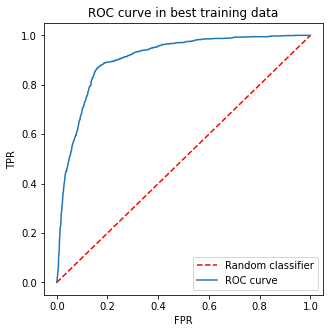

In [ ]:
# Get ROC curve.
tpr3 = final_model_fitted4.stages[-1].summary.roc.select('TPR').toPandas()
fpr3 = final_model_fitted4.stages[-1].summary.roc.select('FPR').toPandas()

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--',label = 'Random classifier')
plt.plot(fpr3,tpr3,label = 'ROC curve')
plt.title('ROC curve in best training data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

In [ ]:
# Get the top 5 most important features.
predictor = ['Age','satisfaction','encoded_Gender','encoded_Type_of_Travel','Flight Distance','encoded_Class']
value = final_model_fitted4.stages[-1].coefficients.tolist()
predictor_list = pd.DataFrame({'predictor':predictor,'value':value}).sort_values(by='value',ascending=False).reset_index(drop=True)

predictor_list.head()

,predictor,value
0,encoded_Class,0.261313
1,Flight Distance,-0.000271
2,encoded_Gender,-0.082252
3,Age,-0.082878
4,satisfaction,-1.806130


### Model 2: Random Forest

In [ ]:
# Using related variables to predict customer type. Using grid search.
if enable_grid_search:
    va = feature.VectorAssembler(inputCols=['Age','satisfaction','encoded_Gender','encoded_Type_of_Travel','Flight Distance','encoded_Class'],
                                 outputCol='features')
    sc = feature.StandardScaler(withMean=True, inputCol='features', outputCol='zfeatures')
    rf = classification.RandomForestClassifier(featuresCol='zfeatures', labelCol='encoded_Customer_Type')
    rf_pipeline = Pipeline(stages=[va,sc,rf])

    grid = ParamGridBuilder().\
        addGrid(rf.numTrees, [40,50,60]).\
        addGrid(rf.maxDepth, [5,10,15]).\
        build()

    all_models = []
    for j in range(len(grid)):
      model = rf_pipeline.fit(training_df, grid[j])
      all_models.append(model)

    evaluator = BinaryClassificationEvaluator(labelCol=rf.getLabelCol(), rawPredictionCol=rf.getRawPredictionCol())
    aucs = [evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    print(aucs)

    best_model_idx = np.argmax(aucs)
    best_model = all_models[best_model_idx]

    print(grid[best_model_idx])
    pass

In [ ]:
# Using best model to predict and get AUC scores.
va = feature.VectorAssembler(inputCols=['Age','satisfaction','encoded_Gender','encoded_Type_of_Travel','Flight Distance','encoded_Class'],
                             outputCol='features')
sc = feature.StandardScaler(withMean=True, inputCol='features', outputCol='zfeatures')
best_rf = classification.RandomForestClassifier(featuresCol='zfeatures', labelCol='encoded_Customer_Type', numTrees=50, maxDepth=10)
best_rf_pipe = Pipeline(stages=[va,sc,best_rf])

evaluator = BinaryClassificationEvaluator(labelCol=best_rf.getLabelCol(), rawPredictionCol=best_rf.getRawPredictionCol())
best_rf_pipe_fitted = best_rf_pipe.fit(training_df)
rf_train_auc = evaluator.evaluate(best_rf_pipe_fitted.transform(training_df))
rf_validation_auc = evaluator.evaluate(best_rf_pipe_fitted.transform(validation_df))
rf_test_auc = evaluator.evaluate(best_rf_pipe_fitted.transform(testing_df))

print("rf_train_bce =", rf_train_auc)
print("rf_validation_bce =", rf_validation_auc)
print("rf_test_bce =", rf_test_auc)

rf_train_bce = 0.970398700638792
rf_validation_bce = 0.9419879631371065
rf_test_bce = 0.9381812478330493


In [ ]:
# Get the top 5 most importance featres.
best_rf_model = best_rf_pipe_fitted.stages[-1]
features = pd.Series(['Age','satisfaction','encoded_Gender','encoded_Type_of_Travel','Flight Distance','encoded_Class'])
importance = best_rf_model.featureImportances.toArray()
rf_feature_importance = pd.DataFrame({'feature': features, 'importance': importance}).sort_values('importance', ascending=False)

display(rf_feature_importance)

,feature,importance
0,Age,0.305854
3,encoded_Type_of_Travel,0.252911
4,Flight Distance,0.195956
1,satisfaction,0.144952
5,encoded_Class,0.079497
2,encoded_Gender,0.020830


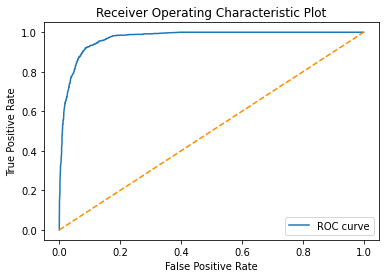

In [ ]:
# Get ROC curve.
fpr = best_rf_model.summary.roc.select('FPR').toPandas()
tpr = best_rf_model.summary.roc.select('TPR').toPandas()
plt.plot(fpr,tpr,label='ROC curve')
plt.plot([0,1], [0,1], color='darkorange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
plt.legend(loc='lower right')

In-depth exploration of the relationship between age and customer type.

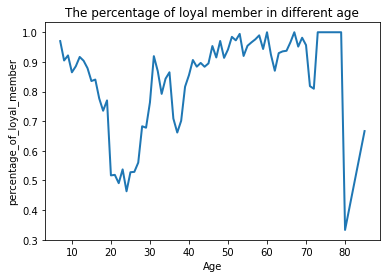

In [ ]:
# In-depth exploration of the relationship between age and customer type.
df = satisfaction_new.groupby("Age").agg((1-(fn.sum("encoded_Customer_Type")/fn.count("encoded_Customer_Type"))).alias("per")).sort("Age")
df = df.toPandas()

x = df["Age"]
y = df["per"]

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)
plt.xlabel("Age")
plt.ylabel("percentage_of_loyal_member")
plt.title("The percentage of loyal member in different age")

plt.show()

In-depth exploration of the relationship between type of travel and customer type.

    Type of Travel       per
0  Business travel  0.736541
1  Personal Travel  0.994046


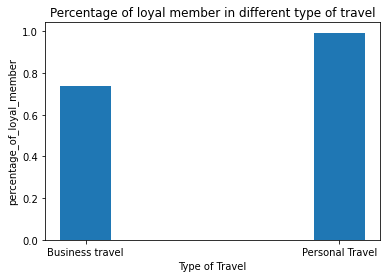

In [ ]:
# In-depth exploration of the relationship between type of travel and customer type.
df2 = satisfaction_new.groupby("Type of Travel").agg((1-(fn.sum("encoded_Customer_Type")/fn.count("encoded_Customer_Type"))).alias("per")).sort("Type of Travel")
df2 = df2.toPandas()
print(df2)

x = df2["Type of Travel"]
y = df2["per"]

# plot
fig, ax = plt.subplots()

ax.bar(x, y,width=0.2, linewidth=4.0)
plt.xlabel("Type of Travel")
plt.ylabel("percentage_of_loyal_member")
plt.title("Percentage of loyal member in different type of travel")

plt.show()

### Model 3: GBT

In [ ]:
# Using related variables to predict customer type. Using grid search.
if enable_grid_search: 
    va = feature.VectorAssembler(inputCols=['Age','satisfaction','encoded_Gender','encoded_Type_of_Travel','Flight Distance','encoded_Class'],
                                 outputCol='features')
    gbt = classification.GBTClassifier(featuresCol='features', labelCol='encoded_Customer_Type')
    gbt_pipeline = Pipeline(stages=[va, gbt])

    grid = ParamGridBuilder().\
        addGrid(gbt.maxIter, [10,20,30]).\
        addGrid(gbt.maxDepth, [3,5,8]).\
        build()

    all_models = []
    for j in range(len(grid)):
      model = gbt_pipeline.fit(training_df, grid[j])
      all_models.append(model)
    
    evaluator = BinaryClassificationEvaluator(labelCol=gbt.getLabelCol(), rawPredictionCol=gbt.getPredictionCol())
    aucs = [evaluator.evaluate(m.transform(validation_df)) for m in all_models]
    print(aucs)

    best_model_idx = np.argmax(aucs)
    best_model = all_models[best_model_idx]

    print(grid[best_model_idx])
    pass

In [ ]:
# Using best model to predict and get AUC scores.
va = feature.VectorAssembler(inputCols=['Age','satisfaction','encoded_Gender','encoded_Type_of_Travel','Flight Distance','encoded_Class'],
                             outputCol='features')

best_gbt = classification.GBTClassifier(featuresCol='features', labelCol='encoded_Customer_Type', maxIter=10, maxDepth=8)
best_gbt_pipe = Pipeline(stages=[va,best_gbt])

evaluator = BinaryClassificationEvaluator(labelCol=best_gbt.getLabelCol(), rawPredictionCol=best_gbt.getPredictionCol())
best_gbt_pipe_fitted2 = best_gbt_pipe.fit(training_df)

gbt_train_auc = evaluator.evaluate(best_gbt_pipe_fitted2.transform(training_df))
gbt_validation_auc = evaluator.evaluate(best_gbt_pipe_fitted2.transform(validation_df))

print("gbt_train_auc =", gbt_train_auc)
print("gbt_validation_auc =", gbt_validation_auc)

gbt_train_auc = 0.8802373693379791
gbt_validation_auc = 0.8319343614820388


### Model 4: Deep Learning

In [ ]:
# Using related variables to predict customer type. Using grid search and 3 times cross validation.
if enable_grid_search:
  mlp2 = classification.MultilayerPerceptronClassifier(seed=0).\
    setFeaturesCol('features').\
    setLabelCol('encoded_Customer_Type').\
    setLayers([6*1,2])

  paramGrid = ParamGridBuilder() \
    .addGrid(mlp.stepSize, [0.1,0.2,0.5]) \
    .addGrid(mlp.maxIter, [200,1000]) \
    .build()

  satisfaction_pipe5 = Pipeline(stages = [va3,sc,mlp2])

  evaluator = BinaryClassificationEvaluator(labelCol=mlp2.getLabelCol(), rawPredictionCol=mlp2.getRawPredictionCol())
  crossval_2 = CrossValidator(estimator=satisfaction_pipe5, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)

  final_model_fitted5 = crossval_2.fit(training_df)

  best_model_index5 = np.argmax(final_model_fitted5.avgMetrics)
  print(paramGrid[best_model_index5])

In [ ]:
# Using best model to predict.
mlp2 = classification.MultilayerPerceptronClassifier(seed=0).\
    setFeaturesCol('features').\
    setLabelCol('encoded_Customer_Type').\
    setStepSize(0.5).\
    setMaxIter(1000).\
    setLayers([6*1,2])

satisfaction_pipe5 = Pipeline(stages = [va3,sc,mlp2])
final_model_fitted5 = satisfaction_pipe5.fit(training_df)
evaluator = BinaryClassificationEvaluator(labelCol=mlp2.getLabelCol(), rawPredictionCol=mlp2.getRawPredictionCol())

In [ ]:
# Get AUC score.
evaluator.evaluate(final_model_fitted5.transform(validation_df))

0.48069964265563164